# Generating DRMI Locking Attempt Plots

In [15]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mtick
import pandas as pd
import itertools
import scipy.stats
%matplotlib inline

## Using JSON File to plot averaged data

After downloading data from `geco_gwpy_dump.py` as `HDF5` files and calculating the average duration of locking attempts from each hour, use the below cells to generate plots. 

Since the data is averaged by hour and most hours have 0 locking attempts, there are a lot of `nan` (not a number) values. Setting this equal to None will leave blank spaces in the plots. Alternately you can also remove all the `nan` values to generate lists with only the actual locking attempts.

In [4]:
with open('durations_aug-jan.json', 'r') as f:
    dictionary = json.load(f)

In [5]:
dur_fail = dictionary['dur_fail']
dur_suc = dictionary['dur_suc']
time = dictionary['time']

In [6]:
nan = None
gpstime = [int(t) for t in time]

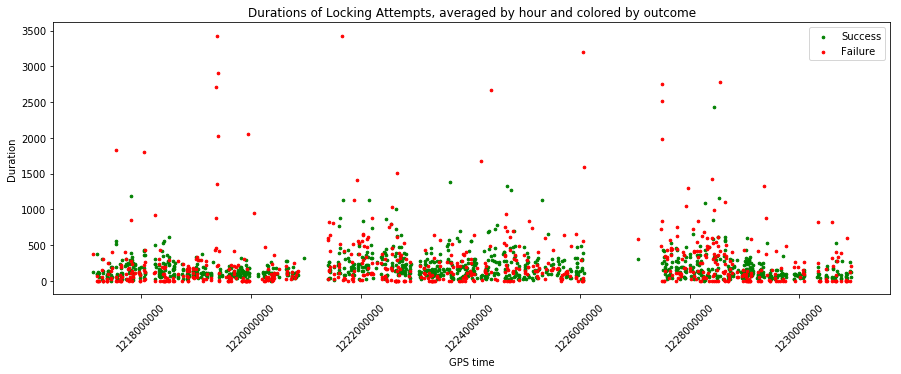

In [7]:
plt.figure(figsize=(15,5))
plt.scatter(gpstime, dur_suc, color='g', label='Success', s=7)
plt.scatter(gpstime, dur_fail, color='r', label='Failure', s=7)
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.xticks(rotation=45)
plt.title('Durations of Locking Attempts, averaged by hour and colored by outcome')
plt.xlabel('GPS time')
plt.ylabel('Duration')
#plt.ylim(0,1000)
#plt.xlim(1228000000, 1228084600)
#plt.vlines(1223100000, 0, 3500)
ax.legend()

Adding subplots to divide the complete dataset:

In [10]:
#TODO

Removing `nan` values and saving the durations and gpstimes to a .csv file (if you would like to access data from another script):

In [13]:
dur_fail = dictionary['dur_fail']
dur_suc = dictionary['dur_suc']
time = dictionary['time']
gpstime = [int(t) for t in time]
dur_suc = np.array(dur_suc)
gpstime = np.array(gpstime)

In [14]:
idx_nan = np.isnan(dur_suc)
idx_notnan = np.where(idx_nan == False)[0]
durations = dur_suc[idx_notnan]
times_at_success = gpstime[idx_notnan]

In [56]:
times_and_durs = pd.DataFrame({'gpstime': times_at_success,
                              'duration': durations})
times_and_durs.to_csv('time_and_duration_successes.csv', encoding='utf-8', index=False)

Opening the .csv and load in the data to another script:

In [9]:
data = pd.read_csv("time_and_duration_successes.csv")
time_at_success = data['gpstime']
duration = data['duration']

## Statistical Tests

Below is code to run a Mann Whitney U Test upon DRMI locking aquisition duration distributions within respective time windows specified in the function `split_into_time_windows`. 

Using the time at success and duration data,conduct a Mann Whitney U Test with the null hypothesis that two different weeks of DRMI locking aquisition data come from the same distribution. This two way test is conducted between every possible seven day period between August 1st, 2018 and January 8th, 2019 (i.e. weeks 8/1/2018-8/8/2018 and 8/2/18-8/9/2018 will be tested against one another,as will weeks 8/1/2018-8/8/2018 and 11/10/2018-11/18-291). The frequency that a day is included within a week which nullifies the null hypothesis that the two samples came from the same distribution is also computed and graphed; this frequency essentially denotes which days are outliers. Outlier days can subsequently be cross referenced with changes to the DRMI locking system (for instance using the A-logs) to examine their changes on the time to achieve lock. A p-value of .05 is chosen for this analysis.

In [11]:
"""Split time_at_success and duration into specified time windows."""
chunk_duration=[]
chunk_success=[]
chunk_time_at_success=[]
def split_into_time_windows(start, end, time_window_size):
    for upper_bin_multiplier in range(1,(end-start)/time_window_size+2):
        lower_bin_multiplier = upper_bin_multiplier-2
        chunk_duration_input=[]
        #chunk_success_input=[]
        chunk_time_at_success_input=[]
        counter=-1
        for time in time_at_success:
            counter+=1
            if start+time_window_size*lower_bin_multiplier<time and time<start+time_window_size*upper_bin_multiplier and counter!=len(time_at_success)-1:
                chunk_duration_input.append(duration[counter])
                #chunk_success_input.append(success[counter])
                chunk_time_at_success_input.append(time)
            elif start+time_window_size*lower_bin_multiplier<time and time<start+time_window_size*upper_bin_multiplier and counter==len(time_at_success)-1:
                chunk_duration_input.append(duration[counter])
                #chunk_success_input.append(success[counter])
                chunk_time_at_success_input.append(time)
                chunk_duration.append(chunk_duration_input)
                #chunk_success.append(chunk_success_input)
                chunk_time_at_success.append(chunk_time_at_success_input)
            elif start+time_window_size*upper_bin_multiplier<time and time_at_success[counter-2] in chunk_time_at_success_input:
                chunk_duration.append(chunk_duration_input)
                #chunk_success.append(chunk_success_input)
                chunk_time_at_success.append(chunk_time_at_success_input)

"""Call split_into_time_windows() to create chunk_duration and chunk_time_at_success
lists which contain all possible weeks, not only subsequent weeks."""

for start in range(1217116818,1217116818,86400):
    end=start+13824000
    split_into_time_windows(start,end,2629746)

"""Mann Whitney U Test as explained above."""

frequency_of_hour = []
def DRMI_locking_duration_u_test(significance_level):
    for i,j in itertools.combinations(chunk_duration,2):
        stat,p = scipy.stats.mannwhitneyu(i, j)
        if p < significance_level:
            for i in chunk_duration:
                x = enumerate(i) in chunk_duration
                frequency_of_hour.extend(chunk_time_at_success[x])
            for j in chunk_duration:
                y = enumerate(j) in chunk_duration
                frequency_of_hour.extend(chunk_time_at_success[y])
        else:
            continue

DRMI_locking_duration_u_test(.05)

"""Plot the results from the mass Mann Whitney U Test in a histogram, as well as
print the days and respective frequencies that a day is included within a week which nullified
the null hypothesis that the two samples came from the same distribution."""

def u_test_frequency_vs_time_at_success_hist(name):
    plt.hist(frequency_of_hour,bins=159,range=[1217116818,1230940818])
    plt.hist(frequency_of_hour,bins=159,range=[1217116818,1230940818])
    plt.show()
    #plt.savefig(name)
    step = 86400
    bin_range = np.arange(1217116818, 1230940818+step, step)
    out, bins  = pd.cut(frequency_of_hour, bins=bin_range, include_lowest=True, right=False, retbins=True)
    out.value_counts().plot.bar()
    print(out.value_counts().head())

u_test_frequency_vs_time_at_success_hist("Historgram16")


SyntaxError: Missing parentheses in call to 'print'. Did you mean print("Statistical difference")? (<ipython-input-11-9a040cf50f9e>, line 35)